In [396]:
# Uncomment code below and run if running into errors with nltk
# import nltk
# nltk.download('punkt')

In [397]:
from collections import Counter
from marked_words_occ import marked_words as get_marked_words_occ
from marked_words import marked_words as get_marked_words_no_occ
from nltk.tokenize import sent_tokenize, word_tokenize

import gensim
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [398]:
no_occ_df = pd.read_csv('original_marked_personas_generated_personas_gpt-3.5-turbo-0125_10.csv')

In [399]:
df = pd.read_csv('generated_personas_occupation_demographics_gpt-3.5-turbo-0125_10.csv')

In [400]:
def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        full_list.append(word[0])
    return full_list

In [401]:
data = list()

In [402]:
dv3_mw_no_occ = {}
for race in no_occ_df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(get_marked_words_no_occ(no_occ_df, [race], ['race'],['a White']))
    dv3_mw_no_occ[race] = outs
temps = []
for race in no_occ_df['race'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(get_marked_words_no_occ(no_occ_df, ['a White'], ['race'],[race]))
    temps.extend(temp)
seen = Counter(temps).most_common()
dv3_mw_no_occ['a White']=[w for w, c in seen if c == 4]


for race in no_occ_df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    outs = pprint(get_marked_words_no_occ(no_occ_df, [race], ['gender'],['M']))
    dv3_mw_no_occ[race] = outs
temps = []
for race in no_occ_df['gender'].unique():
#     print('\n Top words for %s \n-------' % race)
    temp = pprint(get_marked_words_no_occ(no_occ_df, ['M'], ['gender'],[race]))
    temps.extend(temp)

seen = Counter(temps).most_common()
dv3_mw_no_occ['M']=[w for w, c in seen if c == 2]
    
    
# Top words for intersectional groups
for race in no_occ_df['race'].unique():
    for gen in ['M', 'N','F']:
        dv3_mw_no_occ[race+gen] = pprint(get_marked_words_no_occ(no_occ_df, [race, gen], ['race', 'gender'],['a White','M']))

marked_word_similarity = dict()
temp = list()
for key in list(dv3_mw_no_occ.keys()):
    marked_word_similarity[key] = list()
    for word in dv3_mw_no_occ[key]:
        temp.append(word_tokenize(word))
if len(temp) > 0:
    data = temp
# print(data)
print(dv3_mw_no_occ)

{'b': ['dark', 'heritage'], 'a White': ['time', 'sophistication'], 'a Black': ['black', 'resilience', 'strength', 'rich', 'full', 'deep', 'crown', 'african', 'power', 'curls', 'tightly', 'powerful', 'coiled', 'force', 'heritage', 'coils', 'determination', 'proud', 'presence', 'reckoned', 'wisdom', 'faced', 'ancestors', 'curly', 'that', 'bold', 'resilient', 'knowing', 'testament', 'dark', 'unapologetically', 'ebony', 'of', 'grace', 'against', 'beautiful'], 'an Asian': ['asian', 'almondshaped', 'smooth', 'petite', 'modern', 'quiet', 'dark', 'traditional', 'heritage', 'tan', 'sleek', 'cultural', 'respect', 'straight'], 'a Middle-Eastern': ['middleeastern', 'dark', 'olive', 'intricate', 'heritage', 'traditional', 'middle', 'culture', 'thobe', 'community', 'strength', 'my', 'hospitality', 'cultural', 'keffiyeh', 'east', 'strong', 'traditions', 'rich', 'adorned', 'beard', 'faith', 'olivetoned'], 'a Latina': ['latina', 'her', 'fiery', 'dark', 'heritage', 'culture', 'fiercely', 'roots', 'vibra

In [403]:
occupations_df = pd.read_csv('occupations_stats_from_winogender.tsv', sep='\t')

occupations = occupations_df['occupation']


In [404]:
import sklearn
from sklearn.metrics.pairwise import cosine_distances

def compare_words_cos_dist(occ_words, base_words, model):
    sim_words = list()
    if len(base_words) == 0:
        return []
    for occ_word in occ_words:
        total = 0
        count = 0
        for words in occ_word:
            if len(words) > len(base_words):
                smaller_word_group = base_words
                bigger_word_group = words
            else:
                smaller_word_group = words
                bigger_word_group = base_words
            for word in smaller_word_group:
                most_similar = abs(cosine_distances(model.wv[word].reshape(1,-1), model.wv[bigger_word_group[0]].reshape(1,-1)))
                for base_word in bigger_word_group[1:]:
                    most_similar = min(most_similar, abs(cosine_distances(model.wv[word].reshape(1,-1), model.wv[base_word].reshape(1,-1))))
                total += most_similar[0][0]
                count += 1
            if count > 0:
                sim_words.append(total / count)
    return sim_words

In [405]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

def compare_words(occ_words, base_words, model):
    sim_words = list()
    if len(base_words) == 0:
        print('len(base_words) == 0')
        return []
    for occ_word in occ_words:
        total = 0
        count = 0
        for words in occ_word:
            if len(words) > len(base_words):
                smaller_word_group = base_words
                bigger_word_group = words
            else:
                smaller_word_group = words
                bigger_word_group = base_words
            for word in smaller_word_group:
                most_similar = cosine_similarity(model.wv[word].reshape(1,-1), model.wv[bigger_word_group[0]].reshape(1,-1))
                for base_word in bigger_word_group[1:]:
                    most_similar = max(most_similar, cosine_similarity(model.wv[word].reshape(1,-1), model.wv[base_word].reshape(1,-1)))
                total += most_similar[0][0]
                count += 1
            if count > 0:
                sim_words.append(total / count)
    return sim_words

In [406]:
def compare_words_prewritten(occ_words, base_words, model):
    sim_words = list()
    if len(base_words) == 0:
        return []
    for occ_word in occ_words:
        total = 0
        count = 0
        for words in occ_word:
            if len(words) > len(base_words):
                smaller_word_group = base_words
                bigger_word_group = words
            else:
                smaller_word_group = words
                bigger_word_group = base_words
            for word in smaller_word_group:
                most_similar = model.wv.similarity(word, bigger_word_group[0])
                for base_word in bigger_word_group[1:]:
                    most_similar = max(most_similar, model.wv.similarity(word, base_word))
                total += most_similar
                count += 1
            if count > 0:
                sim_words.append(total / count)
    return sim_words

In [407]:
word_count_per_occupation = dict()
all_words = list()

dv3_mw = dict()
for occupation in occupations[1:]:
    print('Occuption:', occupation)
    for race in df['race'].unique():
        # print('\n Top words for %s \n-------' % race)
        outs = pprint(get_marked_words_occ(df, [race], ['race'],['a White'], occupation))
        if race in dv3_mw:
            dv3_mw[race].append([outs])
        else:
            dv3_mw[race] = [[outs]]
    temps = []
    for race in df['race'].unique():
        # print('\n Top words for %s \n-------' % race)
        temp = pprint(get_marked_words_occ(df, ['a White'], ['race'],[race], occupation))
        temps.extend(temp)
    seen = Counter(temps).most_common()
    dv3_mw['a White']=[w for w, c in seen if c == 4]


    for race in df['gender'].unique():
        # print('\n Top words for %s \n-------' % race)
        outs = pprint(get_marked_words_occ(df, [race], ['gender'],['M'], occupation))
        if race in dv3_mw:
            dv3_mw[race].append([outs])
        else:
            dv3_mw[race] = [[outs]]
    temps = []
    for race in df['gender'].unique():
    #     print('\n Top words for %s \n-------' % race)
        temp = pprint(get_marked_words_occ(df, ['M'], ['gender'],[race], occupation))
        temps.extend(temp)
        data += temp

    seen = Counter(temps).most_common()
    dv3_mw['M']=[w for w, c in seen if c == 2]
        
        
    # Top words for intersectional groups
    for race in df['race'].unique():
        for gen in ['M', 'N','F']:
            outs = pprint(get_marked_words_occ(df, [race, gen], ['race', 'gender'],['a White','M'], [occupation]))
            if race+gen in dv3_mw:
                dv3_mw[race+gen].append([outs])
            else:
                dv3_mw[race+gen] = [[outs]]
            data += outs
    for key in dv3_mw.keys():
        if type(key) is not str:
            continue
        new_key = key
        if key[0] == 'b':
            continue
        if "F" in new_key:
            new_key = new_key.replace("F", "W")
    for key in list(dv3_mw.keys()):
        for occ_word_list in dv3_mw[key]:
            for word in occ_word_list:
                if type(word) is str:
                    data.append(word_tokenize(word))
print(dv3_mw)


Occuption: accountant
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'a White': []}
{'target': [], 'b': []}
{'target': [], 'a White': []}
{'target': [], 'a Black': []}
{'target': [], 'an Asian': []}
{'target': [], 'a Middle-Eastern': []}
{'target': [], 'a Latina': []}
{'target': [], 'a Latino': []}
{'target': [], 'M': []}
{'target': [], 'M': []}
{'target': [], 'M': []}
{'target': [], 'M': []}
{'target': [], nan: []}
{'target': [], 'F': []}
{'target': [], 'M': []}
{'target': [], 'N': []}
{'target': [['their', 4.812715959543693], ['her', 6.548488692635528], ['she', 5.132484960939092], ['they', 4.059901495690612], ['are', 2.2425677858889705], ['unique', 2.287373161930702], ['nonbinary', 3.7934152080155203], ['perspective', 1.969622656861074], ['identity', 2.8500264275505653], ['woman', 2.912218839821239], ['diversity', 2.399803997843106], ['wo

In [408]:
print(dv3_mw['a LatinoM'])
print(dv3_mw_no_occ['a LatinoM'])
print(dv3_mw)
for key in list(dv3_mw_no_occ.keys()):
    print(key, dv3_mw_no_occ[key])
    try:
        print(key, dv3_mw[key])
    except:
        continue


[[['latino']], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [['latino']], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [['latino']], [[]], [[]], [['latino']], [[]], [[]]]
['latino']
{'b': [[[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]]], 'a White': [], 'a Black': [[[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]

In [409]:
word_list = [word if type(word) is list else [word] for word in data]
model1 = gensim.models.Word2Vec(sentences=word_list, min_count=1,
                                vector_size=100, window=5)


In [410]:
# print(dv3_mw)
# print(dv3_mw_no_occ)
print(dv3_mw_no_occ)
marked_word_similarity = dict()
for key in dv3_mw.keys():
    if type(key) is not str:
        continue
    new_key = key
    if key[0] == 'b':
        continue
    elif "Latina" in key:
        new_key = new_key.replace("Latina", "Latino")
    # if "F" in new_key:
    #     new_key = new_key.replace("F", "W")
    print('key to compare', dv3_mw[key])
    if len(dv3_mw[key]) == 0:
        continue
    # print('len', len(dv3_mw[key]), dv3_mw)
    print(dv3_mw_no_occ[new_key])
    print(key)
    if key in marked_word_similarity:
        marked_word_similarity[key].append(compare_words(dv3_mw[key], dv3_mw_no_occ[new_key], model1))
    else:
        if type(key) is list:
            print("LIST", key)
        else:
            marked_word_similarity[key] = compare_words(dv3_mw[key], dv3_mw_no_occ[new_key], model1)
    print('nums', marked_word_similarity[key])

{'b': ['dark', 'heritage'], 'a White': ['time', 'sophistication'], 'a Black': ['black', 'resilience', 'strength', 'rich', 'full', 'deep', 'crown', 'african', 'power', 'curls', 'tightly', 'powerful', 'coiled', 'force', 'heritage', 'coils', 'determination', 'proud', 'presence', 'reckoned', 'wisdom', 'faced', 'ancestors', 'curly', 'that', 'bold', 'resilient', 'knowing', 'testament', 'dark', 'unapologetically', 'ebony', 'of', 'grace', 'against', 'beautiful'], 'an Asian': ['asian', 'almondshaped', 'smooth', 'petite', 'modern', 'quiet', 'dark', 'traditional', 'heritage', 'tan', 'sleek', 'cultural', 'respect', 'straight'], 'a Middle-Eastern': ['middleeastern', 'dark', 'olive', 'intricate', 'heritage', 'traditional', 'middle', 'culture', 'thobe', 'community', 'strength', 'my', 'hospitality', 'cultural', 'keffiyeh', 'east', 'strong', 'traditions', 'rich', 'adorned', 'beard', 'faith', 'olivetoned'], 'a Latina': ['latina', 'her', 'fiery', 'dark', 'heritage', 'culture', 'fiercely', 'roots', 'vibra

{'a Black': [], 'an Asian': [], 'a Middle-Eastern': [], 'a Latina': [], 'a Latino': [], 'F': [], 'N': [], 'a WhiteM': [], 'a WhiteN': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'a WhiteF': [0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776, 0.9999999701976776], 'a BlackM': [], 'a BlackN': [0.12754066288471222, 0.04880102723836899, 0.5515731982886791, 0.48837369959801435, 1.0000000596046448, 0.13119008764624596, 0.5515731982886791, 0.4919866155833006, 0.5479237735271454], 'a BlackF': [0.23841457601104463, 0.5268221534788609, 0.5408737640827894, 0.30593717098236084, 1.0, 0.3647761642932892, 0.36911923189957935, 1.0, 0.5311985947191715], 'an AsianM': [1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896, 1.0000001192092896], 'an AsianN': [1.0000001192092896, 0.7199140141407648, 1.00000007

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


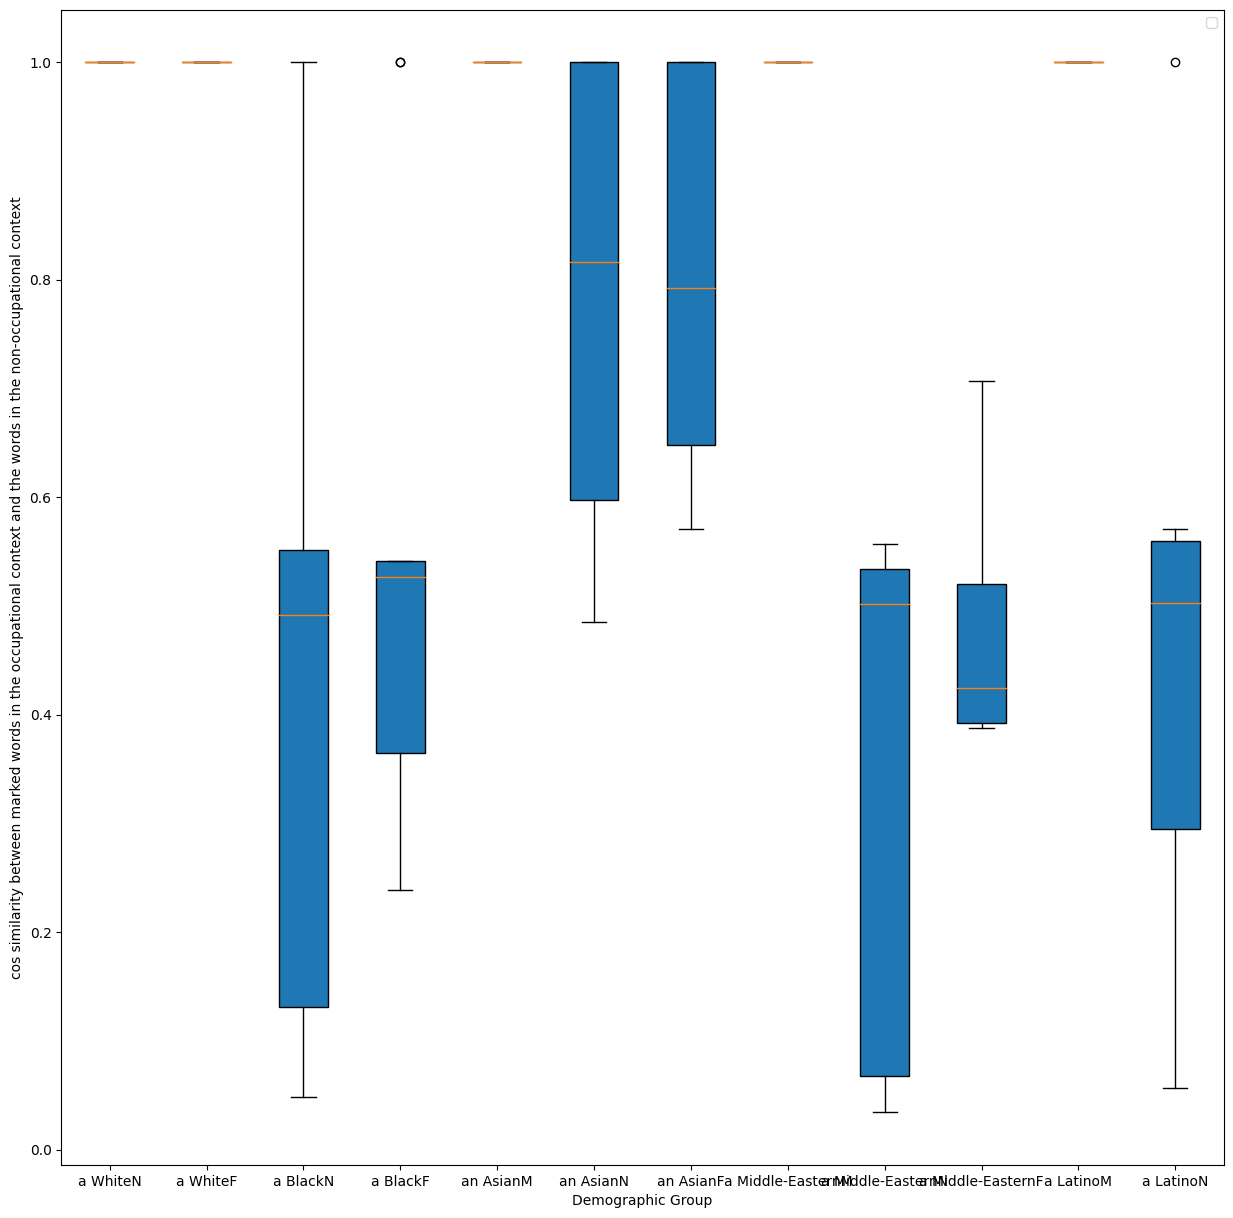

In [411]:
marked_word_similarity_keys = list(marked_word_similarity.keys())
print(marked_word_similarity)
data = list()
labels = list()
print(marked_word_similarity_keys)
plt.figure(figsize=(15,15))
for key in marked_word_similarity_keys:
    if len(marked_word_similarity[key]) == 0:
        continue
    # data.append(marked_word_similarity[key])
    print(marked_word_similarity[key])
    data.append(marked_word_similarity[key])
    # data.append(_data)
    labels.append(key)
    # print(data)
    # print(marked_word_similarity[key])
print(data)
print(labels)
plt.boxplot(data,notch=False,  # notch shape
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels)
plt.xlabel('Demographic Group')
plt.ylabel('cos similarity between marked words in the occupational context and the words in the non-occupational context')
plt.legend()
plt.show()